#### Final classifier:
I will transform the problem into a binary one (healthy , disease), and use the LogisticRegression model from hierarchical_approach1.ipynb. 

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pickle as pk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay, make_scorer, recall_score
from sklearn.linear_model import LogisticRegression
import time

In [78]:
# set seaborn theme

sns.set_theme(context='notebook', style='whitegrid', palette='bright')

In [73]:
# import training

with open("x_training.pkl" , "rb") as file:
    x_training = pk.load(file)
with open("y_training.pkl" , "rb") as file:
    y_training = pk.load(file)

# import testing

with open("x_benchmark.pkl" , "rb") as file:
    x_testing = pk.load(file)
with open("y_benchmark.pkl" , "rb") as file:
    y_testing = pk.load(file)

In [8]:
# transform outputs in binary (0 --> 0 , 1 or 2 --> 1)
y_training_binary = np.where(y_training <= 1 , y_training , 1)
y_testing_binary = np.where(y_testing <= 1 , y_testing , 1)

# check that disease proportion is the same in the two datasets
print((y_training_binary == 1).mean())
print((y_testing_binary == 1).mean())

In [9]:
# initialize model

logistic_reg = Pipeline([
    ('scaler', StandardScaler()), 
    ('lgr', LogisticRegression(
        solver="lbfgs", 
        max_iter=2000, 
        class_weight="balanced"
    ))
])

In [10]:
# use custom function to predict using desired threshold

def predict_custom(model, x, threshold):

    ''' function to enable the use of a selected threshold
        for classification'''
    
    # predict probabilities instead of just predict
    probs = model.predict_proba(x)[:, 1]
    # apply thresholds
    return (probs >= threshold).astype(int)

In [12]:
# fit on training
start = time.time()

logistic_reg.fit(x_training , y_training_binary)

end= time.time()

print(f"Training took {(end-start):.1f} seconds")
# predict on testing using optimal threshold 0.2
y_pred = predict_custom(logistic_reg , x_testing , 0.2)

Training took 0.3 seconds


#### Overall performance: confusion matrix

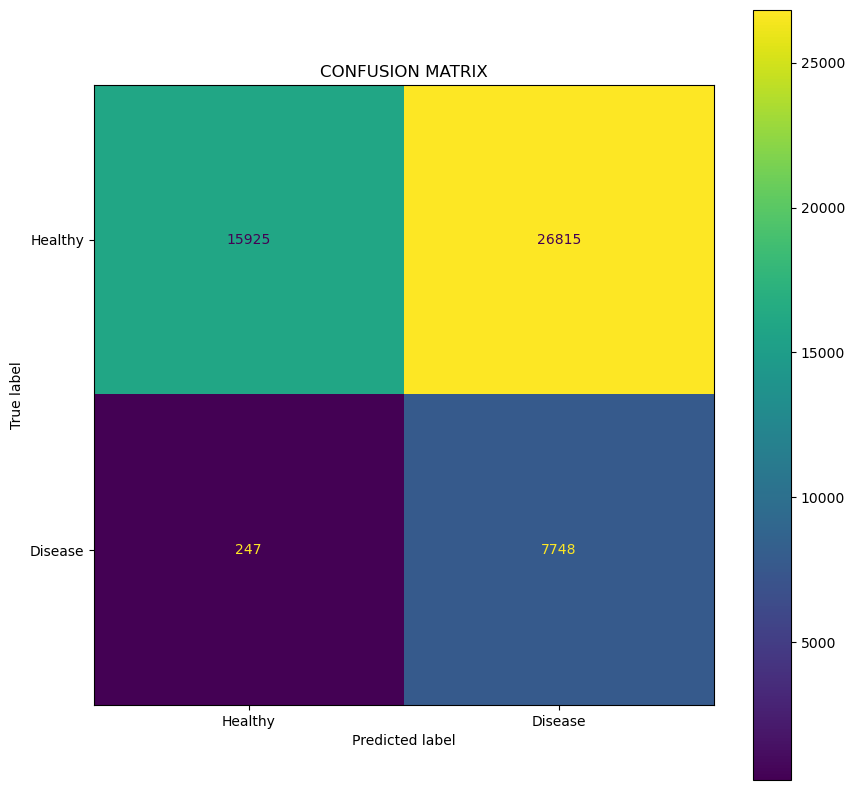

False alarms: 26815
Catches:  7748
Ratio (number of false alarms for each correct prediction): 3.5
---------------------------------------------------------------------------------------------------------------------------
Precision:   0.22
Recall:      0.97
Specificity: 0.37


In [19]:
cm = confusion_matrix(y_testing_binary, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Disease'])

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap='viridis', ax=ax, values_format='d') 
plt.title(f"CONFUSION MATRIX")
plt.show()

# Let's see how many healthy people misclassifications we have against correct disease classification
print(f"False alarms: {cm[0,1]}\nCatches:  {cm[1,1]}\nRatio (number of false alarms for each correct prediction): {cm[0,1]/cm[1,1]:.1f}")
print("---------------------------------------------------------------------------------------------------------------------------")
print(f"Precision:   {(cm[1,1] / (cm[1,1] + cm[0,1])):.2f}")
print(f"Recall:      {(cm[1,1] / (cm[1,1] + cm[1,0])):.2f}")
print(f"Specificity: {(cm[0,0] / (cm[0,0] + cm[0,1])):.2f}")

#### Discussion:

For each correct disease prediction, we have 3.5 false positives. In fact, precision is low at 22%.  
Recall on the other hand is very high.  As I said previously, it is also important to look at how many of the 3% disease that we did not spot are diabetics and prediabetics.  
Specificity is low 0.37, meaning that the model only correclty identifies 37% of healthy people.  
As a screening tool, this is not optimal.  
Being able to send home at least 60% of people without directing them to further and more costly investigations, such as blood glucose tests, would have been a good result, but I have to settle for this result.  
It is important to remember that using HistGradientBoosting would probably increse specificity to around 40%, but at the cost of many more false negatives.  
Here I only present LogisticRegression becuase it is cheaper, and has comparable results, but for hostpitals that need to cut costs, HistGradientBoosting is still an option.

#### False negatives analysis

In [113]:
# add a new "prediction" and "class" column to x_testing dataframe:

prediction_df = x_testing.copy()
prediction_df["class_"] = y_testing
prediction_df["prediction"] = y_pred

In [114]:
# create df with only healthy predictions
FN_df = prediction_df.query("(prediction == 0) and (class_ == 1 or class_ == 2)")

FN_plot = FN_df.assign(
    Condition = FN_df["class_"].map({1: 'Pre-diabetes', 2: 'Diabetes'})
)

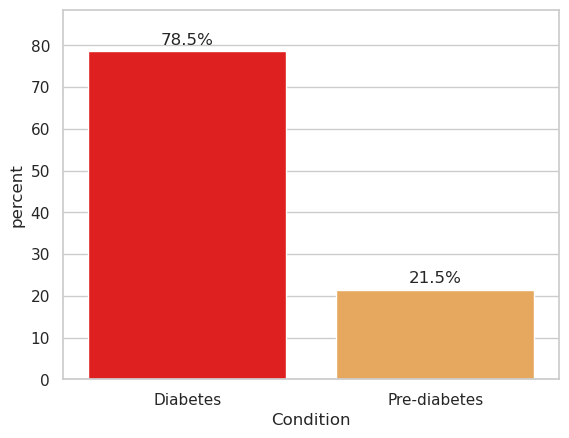

In [115]:
my_colors = {
    "Pre-diabetes": 'xkcd:light orange', 
    "Diabetes": 'red'    
}

hist = sns.countplot(
    data=FN_plot,
    x=FN_plot["Condition"],
    hue=FN_plot["Condition"],
    palette=my_colors,
    stat = "percent"
)

for container in hist.containers:
    hist.bar_label(container, fmt='%.1f%%', padding=3, fontsize=12)

current_max = FN_plot['Condition'].value_counts(normalize=True).max() * 100
plt.ylim(0, current_max + 10) 
plt.show()

In [130]:
print(f"Number of pre-diabetes false negatives:                {FN_df.query("class_ == 1").shape[0]}")
print(f"Total number of pre-diabetics in testing set:          {prediction_df.query(" class_ == 1").shape[0]}")
print(f"Percentage of false negative pre-diabetes predictions: {(FN_df.query('class_ == 1').shape[0] / prediction_df.query('class_ == 1').shape[0])*100:.2f}%\n")
print(f"Number of diabetes false negatives:                    {FN_df.query("class_ == 2").shape[0]}")
print(f"Total number of diabetics in testing set:              {prediction_df.query("class_ == 2").shape[0]}")
print(f"Percentage of false negative diabetes predictions:     {(FN_df.query("class_ == 2").shape[0] / prediction_df.query("class_ == 2").shape[0])*100:.2f}%\n")

Number of pre-diabetes false negatives:                53
Total number of pre-diabetics in testing set:          926
Percentage of false negative pre-diabetes predictions: 5.72%

Number of diabetes false negatives:                    194
Total number of diabetics in testing set:              7069
Percentage of false negative diabetes predictions:     2.74%



#### Discussion:
Among the False Negatives, 78 % belong to the diabetes class, while 21.5% belong to the prediabetes class.  
As I said previously, the goal was to reduce misclassification of prediabetics since diabetic people probably already know they have diabetes.  
To have just 53 prediabetics misclassified on a total of 926 prediabetics (6% of them) is a good achievement.  
Many more diabetics have been miscalssified, but given they are more represented in the dataset, only 3% of them are misclassified.  
Even if the model has been optimized to recall prediabetics, their misclassification rate is higher than that of diabetics, highlighting the difficulty in distinguishing them from healthy individuals

In [131]:
# vedere FalseNegative distribuzioni varie 
# fare clusterizzazioni 
# sentire gemini che cazzo dice